In [209]:
# to_save, to_load = False, True
session_file = "./tmp/TIC_75722876_EA.ipynb.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/TIC_75722876_EA.ipynb.pkl


In [3]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 75722876  Analysis (EA)

- new VSX entry


## TESS Data

In [4]:
tic = 75722876

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 25,2020,SPOC,120,75722876,0.0,G022238
1,TESS Sector 26,2020,SPOC,120,75722876,0.0,G022238
2,TESS Sector 40,2021,TESS-SPOC,600,75722876,0.0,N/A
3,TESS Sector 52,2022,TESS-SPOC,600,75722876,0.0,N/A
4,TESS Sector 53,2022,TESS-SPOC,600,75722876,0.0,N/A
5,TESS Sector 74,2024,SPOC,120,75722876,0.0,G06092
6,TESS Sector 79,2024,SPOC,120,75722876,0.0,G06092
7,TESS Sector 80,2024,SPOC,120,75722876,0.0,G06092


LightCurveCollection of 8 objects:
    0: <TessLightCurve LABEL="TIC 75722876" SECTOR=25 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 75722876" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 75722876" SECTOR=40 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 75722876" SECTOR=52 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 75722876" SECTOR=53 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 75722876" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 75722876" SECTOR=79 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 75722876" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

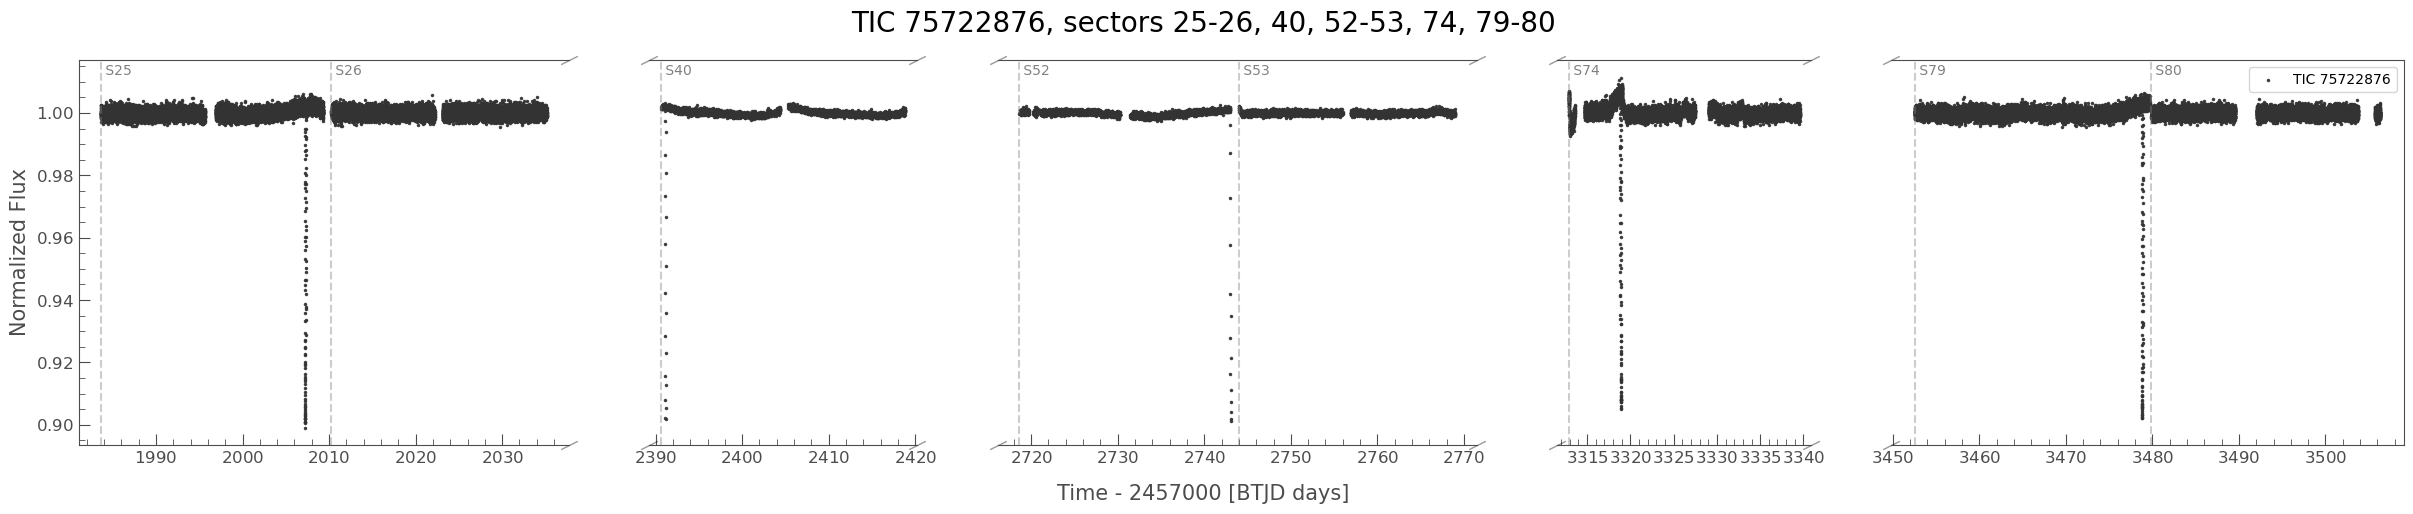

In [169]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=9, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(0.9985, 1.001) for ax in axs];

## Gaia DR3 info (coordinate, etc.)

In [8]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


The target is also listed as an AB and SB with ~500 dperiod in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=I/357&-c=17%3A55%3A59.25%20%2B45%3A52%3A26.42&-c.u=arcsec&-c.r=15&-c.eq=J2000&-out.add=_r&-out.add=_p&-sort=_r)


In [9]:
primary_name = f"TIC {tic}"
primary_name

'TIC 75722876'

## Combining all data

- Archival ASAS-SN, CRTS, Hipparcos (Tycho)  data exist, but they do not have the photometric precison needed:

http://asas-sn.ifa.hawaii.edu/skypatrol/objects/94490409181

http://nunuku.caltech.edu/cgi-bin/getcssconedb_release_img.cgi?RADec=270.95336+38.96054&Rad=0.2&DB=photcat&OUT=csv&SHORT=short&PLOT=plot#simtable

https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ63a724f430cc2&-out.add=.&-source=I/239/tyc_main&recno=304478  ,  
https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?I/239&3102-253-1

### SuperWASP

Note: SuperWASP data considered in passband CV in VSX, though the following paper suggests it's later fitted with a brodband 400-700nm filter
- https://iopscience.iop.org/article/10.1086/508556

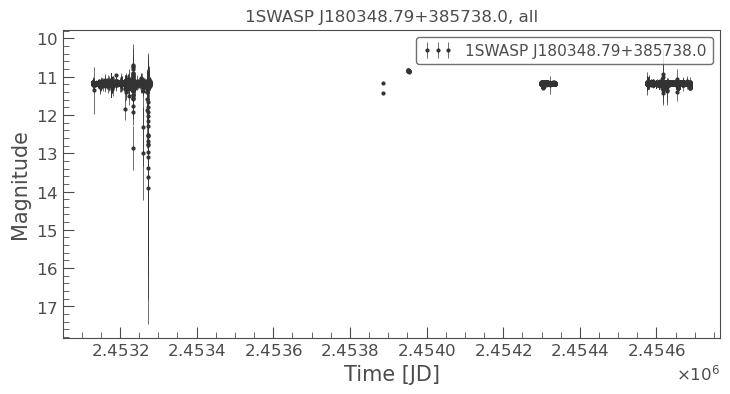

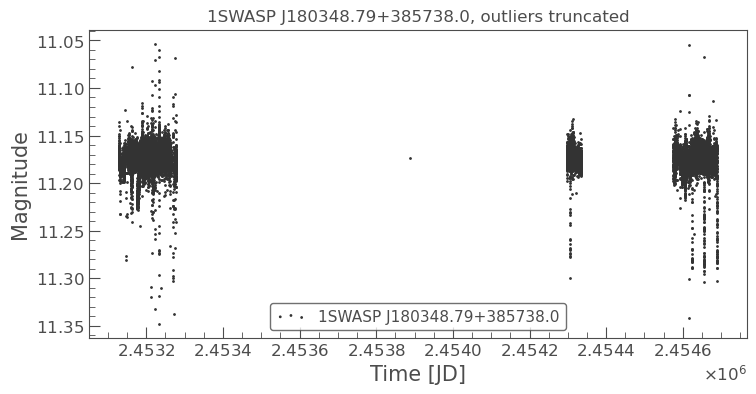

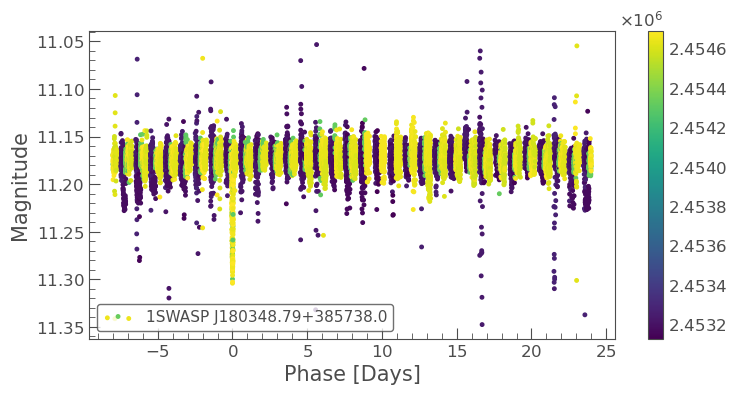

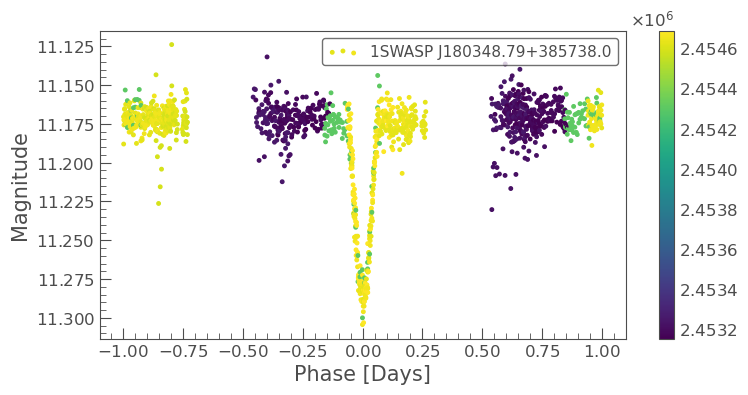

In [26]:
import lightkurve_ext_readers as lker

# https://wasp.cerit-sc.cz/klimes/?object=1SWASP%20J180348.79%2B385738.0
_lc = lker.read_superwasp_dr1_data("1SWASP J180348.79+385738.0")
_lc = lke.to_flux_in_mag_by_normalization(_lc, base_mag=11.17363)  # from SuperWASP
ax = tplt.errorbar(_lc);
ax.set_title(_lc.label + ", all");

_lc = _lc.truncate(11.05, 11.35, column="flux") 
# ax = tplt.errorbar(_lc);
ax = tplt.scatter(_lc);
ax.set_title(_lc.label + ", outliers truncated");

_lc_f = _lc.fold(period=31.991200, epoch_time=Time(2007.25, format="btjd").to_value("jd"), wrap_phase=31.991200*0.75)  # rough initial epoch / period to gauge usefulness of the data
ax = tplt.scatter(_lc_f, s=25, c=_lc_f.time_original.value);

_lc_f_t = _lc_f.truncate(-1, 1)
ax = tplt.scatter(_lc_f_t, s=25, c=_lc_f_t.time_original.value);

lc_swasp = _lc

### Do Actual combining

TESS # data points: 101306
1SWASP # data points: 19469


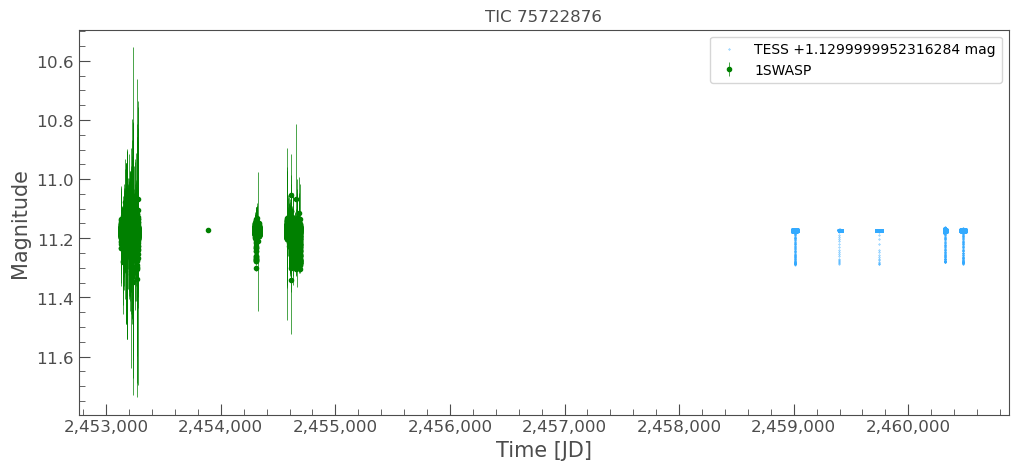

In [30]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "1SWASP": lc_swasp,
    }, 
    shift_to="1SWASP",

)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Final epoch / period / duration

- epoch / period / duration  from TCE

https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC75722876S0014S0086TCE1 , 
https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019199201929-s0014-s0086-0000000075722876-01-00971_dvs.pdf


In [109]:
# debug weird rounding error in the plot label
reload(lkem) 

# type(np.nanmedian(lc_combined_dict["TESS"].flux)  # MaskedQuantity
# np.nanmedian(lc_tess.flux).value, np.nanmedian(lc_swasp.flux).value  # the source of the mag shift
# print(lc_combined_dict["TESS"].meta.get("FLUX_SHIFT", None).value)  # 1.1312151


# they  somehow return the werid 1.1299999952316284, instead of 1.13
# f"{np.round(lc_combined_dict["TESS"].meta.get("FLUX_SHIFT", None), 2)}"
# f"{(np.round((lc_combined_dict["TESS"].meta.get("FLUX_SHIFT", None).value), 2))}"  
lkem.get_label_of_source(lc_combined_dict, "TESS", mag_shift_precision=2)

# # export the underlying LC data to reproduce in isolated env later
# from astropy.table import Table

# Table(data=dict(flux=lc_tess.flux)).write("tmp/tic75722876_flux.csv", overwrite=True)
# Table(data=dict(flux=lc_swasp.flux)).write("tmp/tic75722876_swasp_flux.csv", overwrite=True)

Adopted period / epoch / duration_hr:  31.99117 2459007.248 3.19


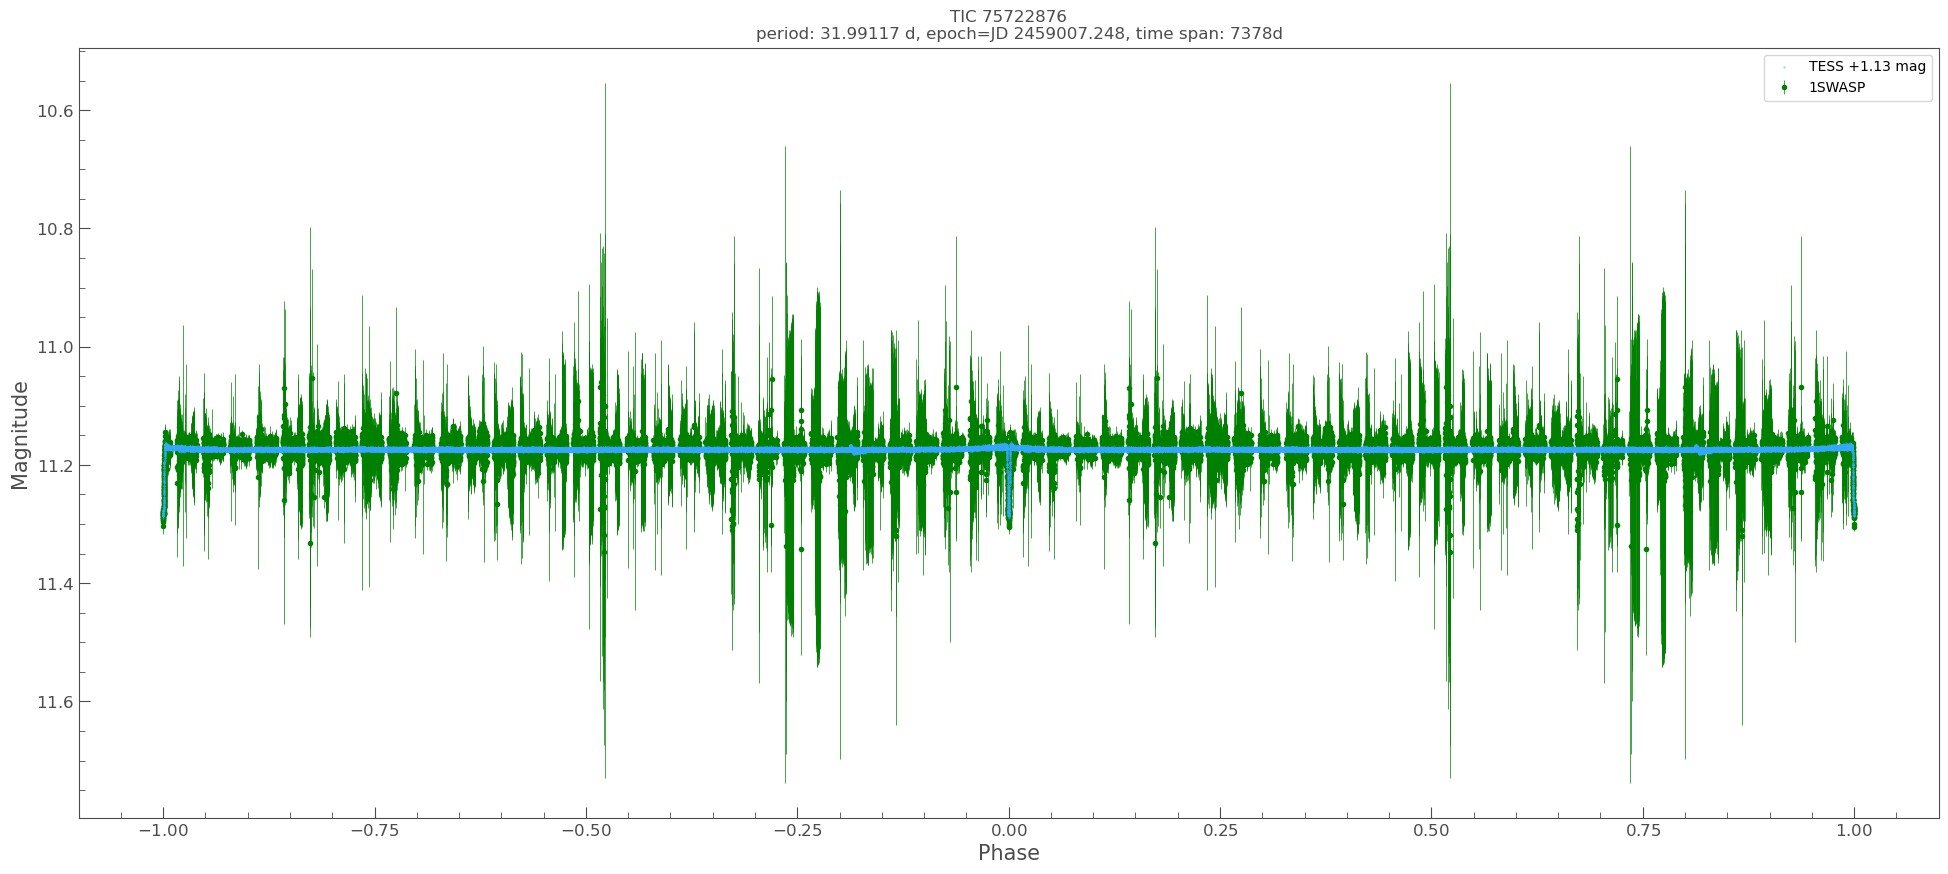

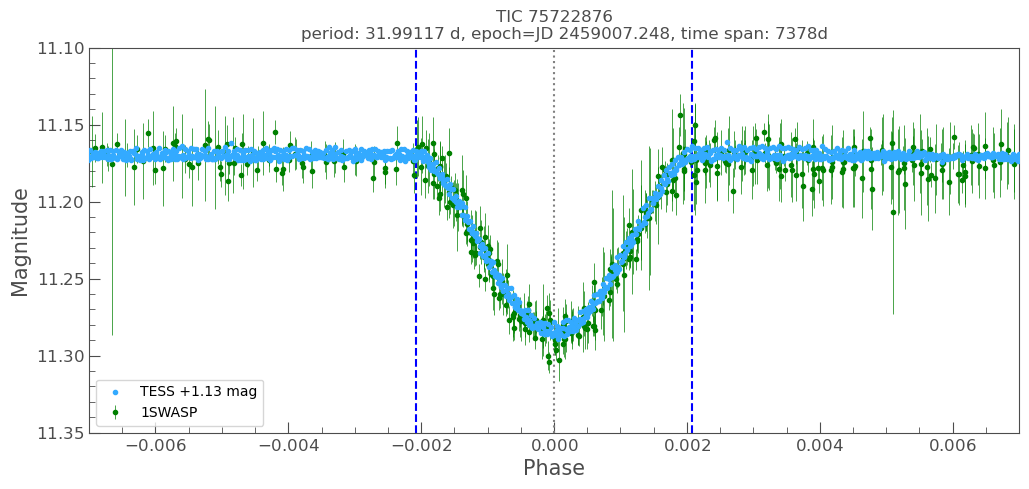

In [182]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 31.99117
epoch_time_btjd_final = 2007.2491
epoch_time_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_btjd_final, target_coord), 3)  # need 3 digit to ensure it does look off visually

duration_hr_min_i_final = 3.19


print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final)

# --- Plot them to verify ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 9
plot_options_zoom[0][1]["zorder"] = 3  # move to the front, default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,
);
ylim = (11.35, 11.10)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.007, 0.007);  # to see primary in details


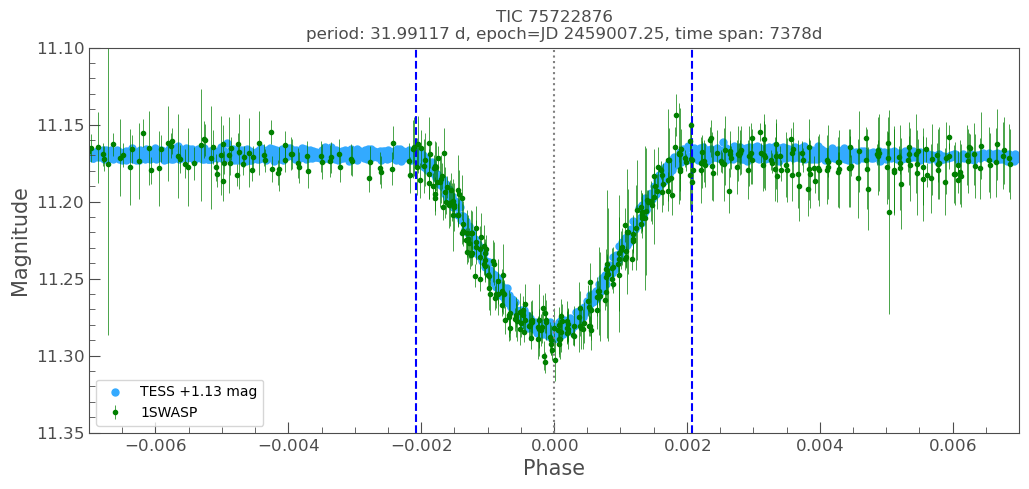

In [183]:
# demonstrate the differnce if Min I epoch is in 2 digits instead of 3 digits

_et = round(epoch_time_hjd_final, 2)
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(_et  , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.007, 0.007);  # to see primary in details


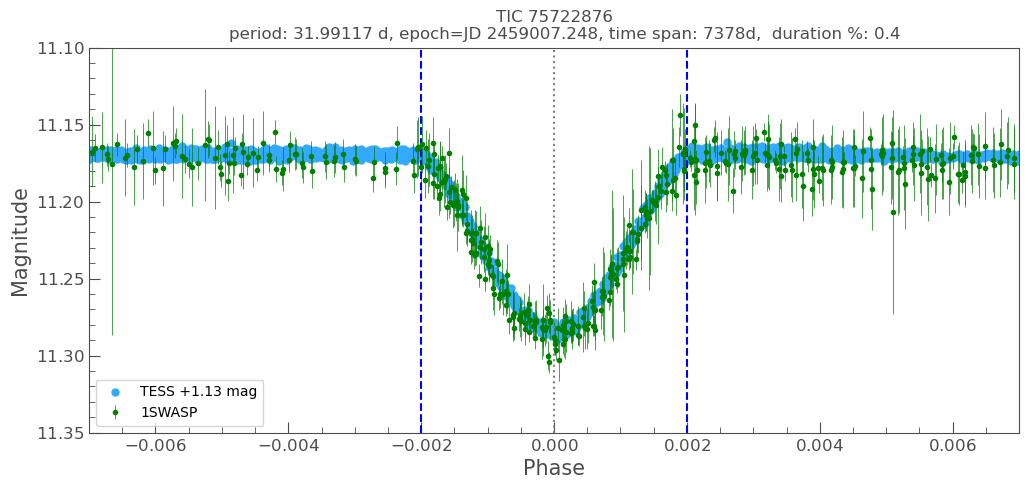

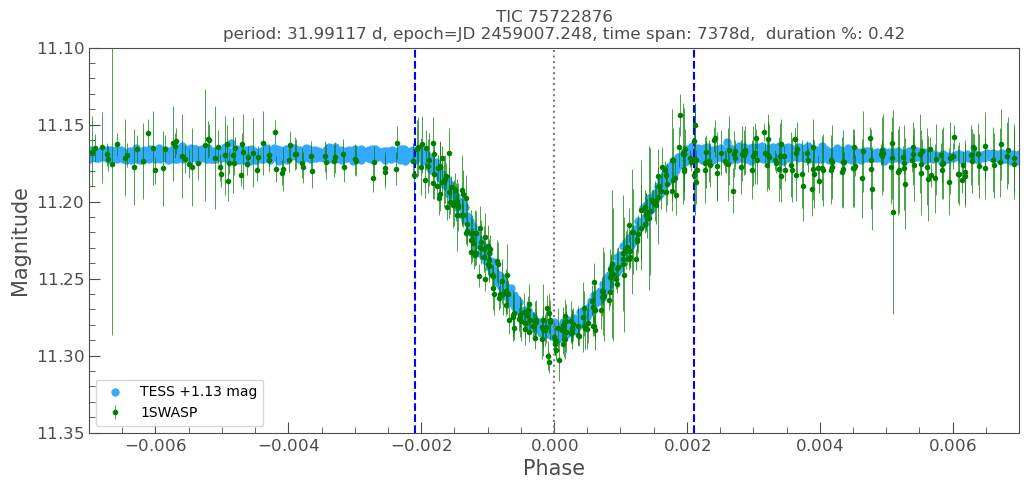

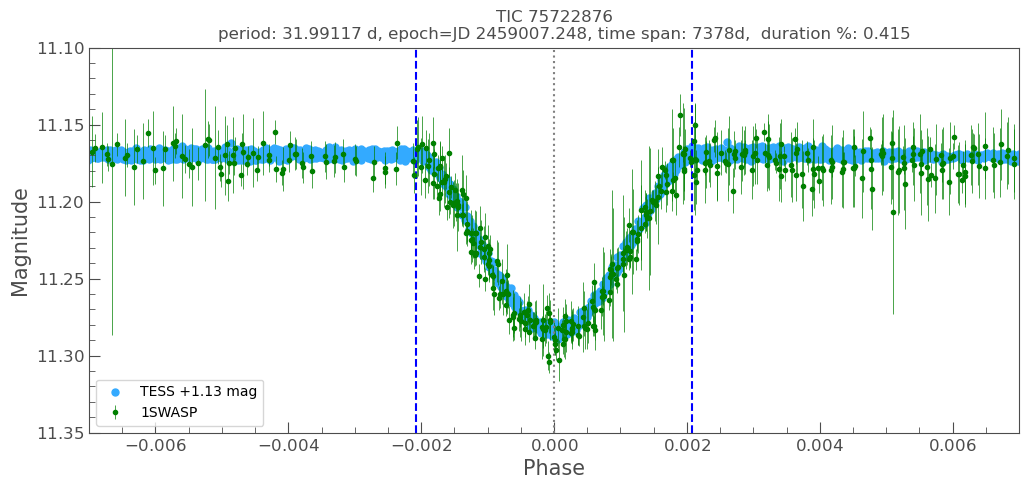

In [193]:
# demonstrate the precision difference in duration percentage 

for _precision in [1, 2, 3]: 
    _dur_pct = round(100 * duration_hr_min_i_final / 24 / period_final, _precision)
    _dur_hr = _dur_pct /100 * 24 * period_final
    # zoom plot Min I
    # - make TESS more visible:  larger dots
    plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
    plot_options_zoom[0][1]["s"] = 25
    ax, lc_f_res = lkem.fold_n_plot_multi_bands(
        lc_combined_dict,
        period=period_final,
        epoch=Time(epoch_time_hjd_final  , format="jd", scale="utc"),
        phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
        target_name=primary_name,
        duration_hr=_dur_hr,  # for plotting only
        figsize=(12, 5),
        plot_options=plot_options_zoom,
        # mag_shift_precision=2,  #
    );
    ax.set_ylim(*ylim);
    ax.legend(loc="lower left");
    ax.axvline(0, c="gray", linestyle="dotted");
    ax.set_xlim(-0.007, 0.007);  # to see primary in details
    ax.set_title(ax.get_title() + f",  duration %: {_dur_pct}");
    # print(_dur_pct, _dur_hr, duration_hr_min_i_final) 

In [ ]:
# demonstrate the difference in duration : 3 decimal point (in percetage)

_dur_pct = round(100 * duration_hr_min_i_final / 24 / period_final, 3)
_dur_hr = _dur_pct /100 * 24 * period_final
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final  , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=_dur_hr,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.007, 0.007);  # to see primary in details
ax.set_title(ax.get_title() + f",  duration %: {_dur_pct}");

_dur_pct, _dur_hr, duration_hr_min_i_final

## Determine Magnitude Range / Amplitude


In [179]:
lc = lc_combined_dict["TESS"]

In [ ]:
# determine max, zoom around max :not needed, the median is basically the max

# for max_offset in [0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]:
#     lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
#     # print("Max mag # num data points:", len(lc_zoom_max))
#     max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
#     print(max_offset, round(float(max_flux_mag), 4))

# # max is roughly at +0.7 / +0.75 d
# lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
# lc_f_trunc = lc_f.truncate(0.75 - 0.2, 0.75 + 0.2)
# ax = tplt.lk_ax(figsize=(12, 8))
# ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, alpha=0.5);
# ax.axhline(12.2448, c="purple");

Min I mag # num data points: 6
['11.1725', '11.1736', '11.2852']


0.112

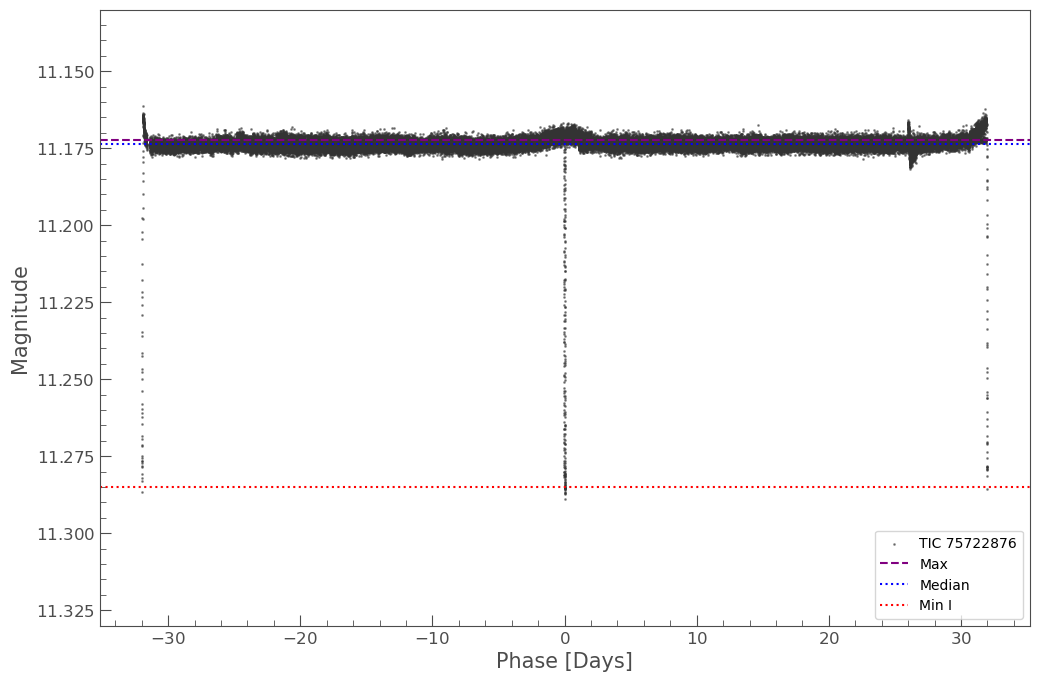

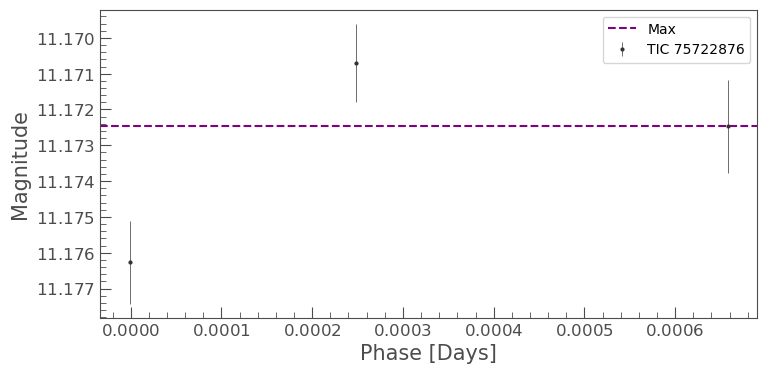

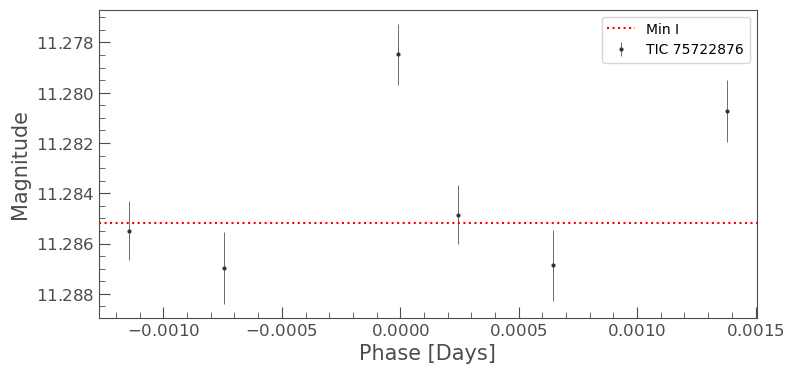

In [180]:
# %matplotlib widget
%matplotlib inline

# From TESS data

# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

# no max neded, medain is basically maax
# lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 0.75, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)  
# print("Max mag # num data points:", len(lc_zoom_max))
# max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 2 /24/60, 0 + 2 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
# print("Min II mag # num data points:", len(lc_zoom_min_ii))
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_max, marker="o");
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

# ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag]])  # , min_ii_flux_mag


# # TESS only data, to report mean V mag and ampitude in TESS
# mean_flux_v_mag = np.round(rs_all_cols["Vmag"][0], 2)  # V converted from Gaia DR3 - here I use other sources

# amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 3)  # in TESS band, probably don't have 4 digit precison

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  

# amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  

(amp_min_i_flux_mag )  # amp_flux_mag,   , amp_min_ii_flux_mag

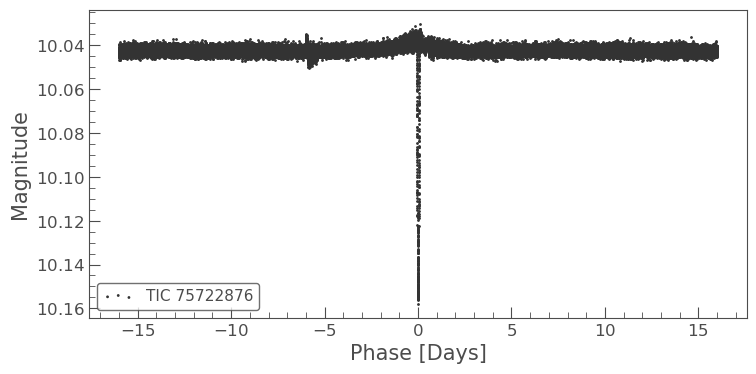

In [148]:
tplt.scatter(lc_f_all);

### Per-cycle plot of Min I

- to find out whether the bump surround Min I is in isolated cycle(s), or a general pattern (isolated in this case)

Num. cycles: 5
Period=31.99117 ; epoch=2459007.248


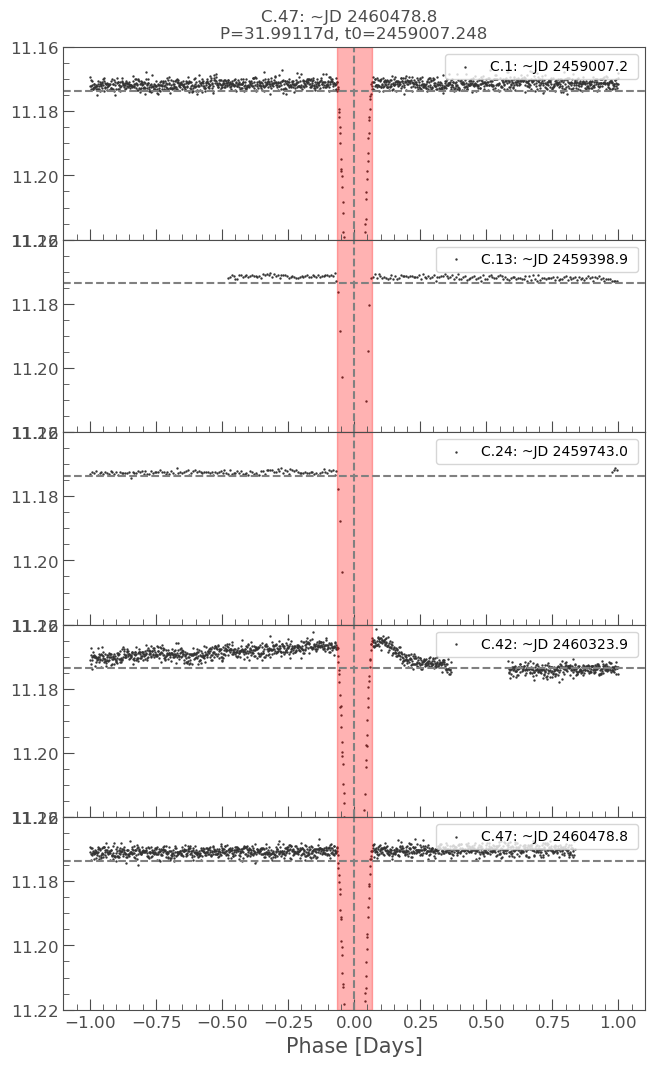

In [181]:
# --- specify the data
_lc_all = lc_combined_dict["TESS"]
_per, _t0, _dur_hr = period_final, epoch_time_hjd_final, duration_hr_min_i_final

# --- foled lightcurve
lc_f_all = _lc_all.fold(period=_per, epoch_time=_t0)
lc_f_c = []
for i in np.unique(lc_f_all.cycle):
    lc_f =  lc_f_all[lc_f_all.cycle == i]
    if len(lc_f.truncate(_dur_hr/24 * -0.25, _dur_hr/24 * 0.25)) < 5:
        # skip the cycle if no or limited data in mid eclipse
        continue
    est_midpoint =  (lc_f.time_original.max().value + lc_f.time_original.min().value) / 2
    lc_f.label = f"C.{i}: ~{lc_f.time_original.format.upper()} {est_midpoint:.1f} "   # label with cycle number
    lc_f_c.append(lc_f)
lc_f_c = lk.LightCurveCollection(lc_f_c)
print("Num. cycles:", len(lc_f_c))
print(f"Period={_per} ; epoch={_t0}" )

# --- now do the acuual phase plot

with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(len(lc_f_c), 1, sharex=True,  squeeze=True, figsize=(  # vertical
        7.5, 2.5 * len(lc_f_c)
    ));
    is_vertical = True

    # fig, axs = plt.subplots(1, len(lc_f_c), sharex=True, sharey=True, squeeze=True, figsize=(  # horizontal
    #     2 * len(lc_f_c), 3
    # ));
    # is_vertical = False

    fig.subplots_adjust(wspace=0, hspace=0)
    if len(lc_f_c) == 1:
        axs = [axs]

for i, lc_f  in enumerate(of_sectors(lc_f_c[:])):
    ax = axs[i]
    lc_f = lc_f.truncate(-1, 1)
    
    ax = tplt.scatter(lc_f, ax=ax, 
                      s=2,
                      # c="gold", alpha=0.7, s=49.0,
                      # c="black", s=49.0,
                     )

    
    ax.legend(loc="upper right");

    ax.axvline(0, linestyle="--", c="gray")
    ax.axvspan(0 - _dur_hr / 24 * 0.5, 0 + _dur_hr / 24 * 0.5, color="red", alpha=0.3);
    ax.axhline(median_flux_mag, linestyle="--", c="gray" , label="median") 
    
    ax.set_ylim(11.22, 11.16)

    if is_vertical and lc_f is not lc_f_c[-1]:
        ax.set_ylabel(None)
    if not is_vertical and i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    if i == 0 and lc_f.author == "TGLC":
        ax.set_ylabel(lc.meta.get("FLUX_ORIGIN", "Flux"));

axs[0].set_title(f"{lc_f.label} \nP={lc_f.period.value}d, t0={lc_f.epoch_time.value}");

## Plots for VSX

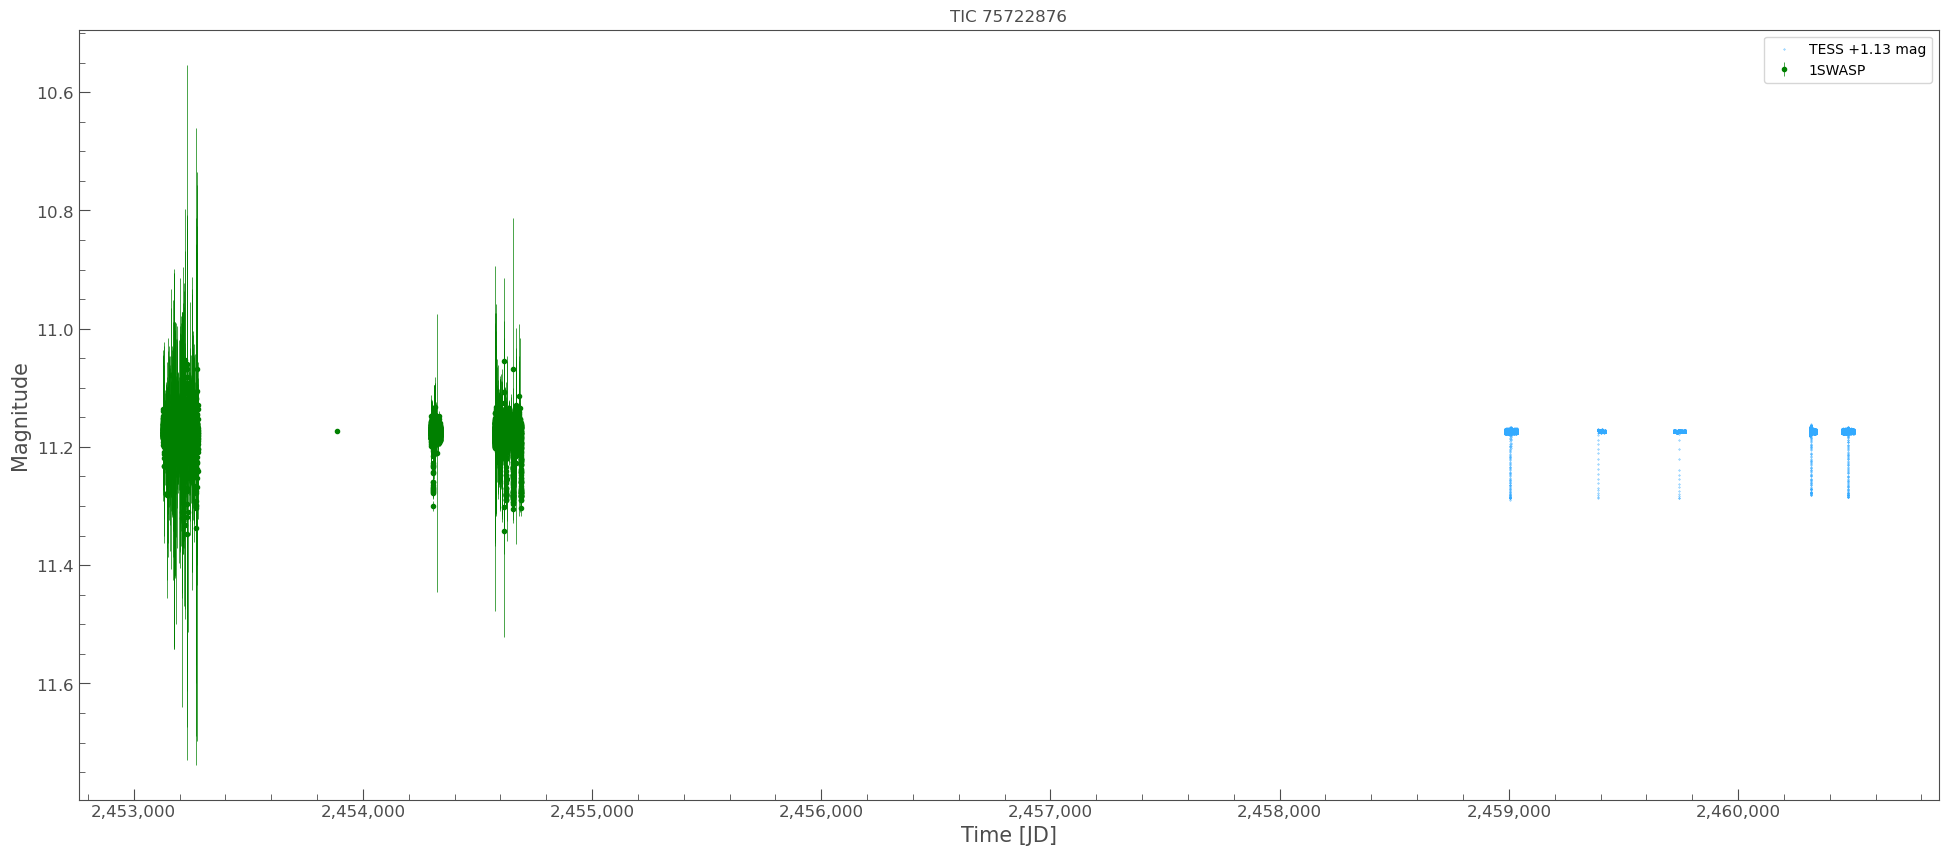

In [119]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
# ax.set_title(ax.get_title() + "");

#### Phase Plot



In [137]:
lkem.get_default_plot_multi_bands_options_copy()

[('scatter', {'c': '#3AF', 's': 0.1, 'alpha': 1.0}),
 ('errorbar', {'marker': '.', 'c': 'green', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'pink', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'violet', 'linewidth': 0.5, 'ls': 'none'}),
 ('errorbar', {'marker': '.', 'c': 'orange', 'linewidth': 0.5, 'ls': 'none'})]

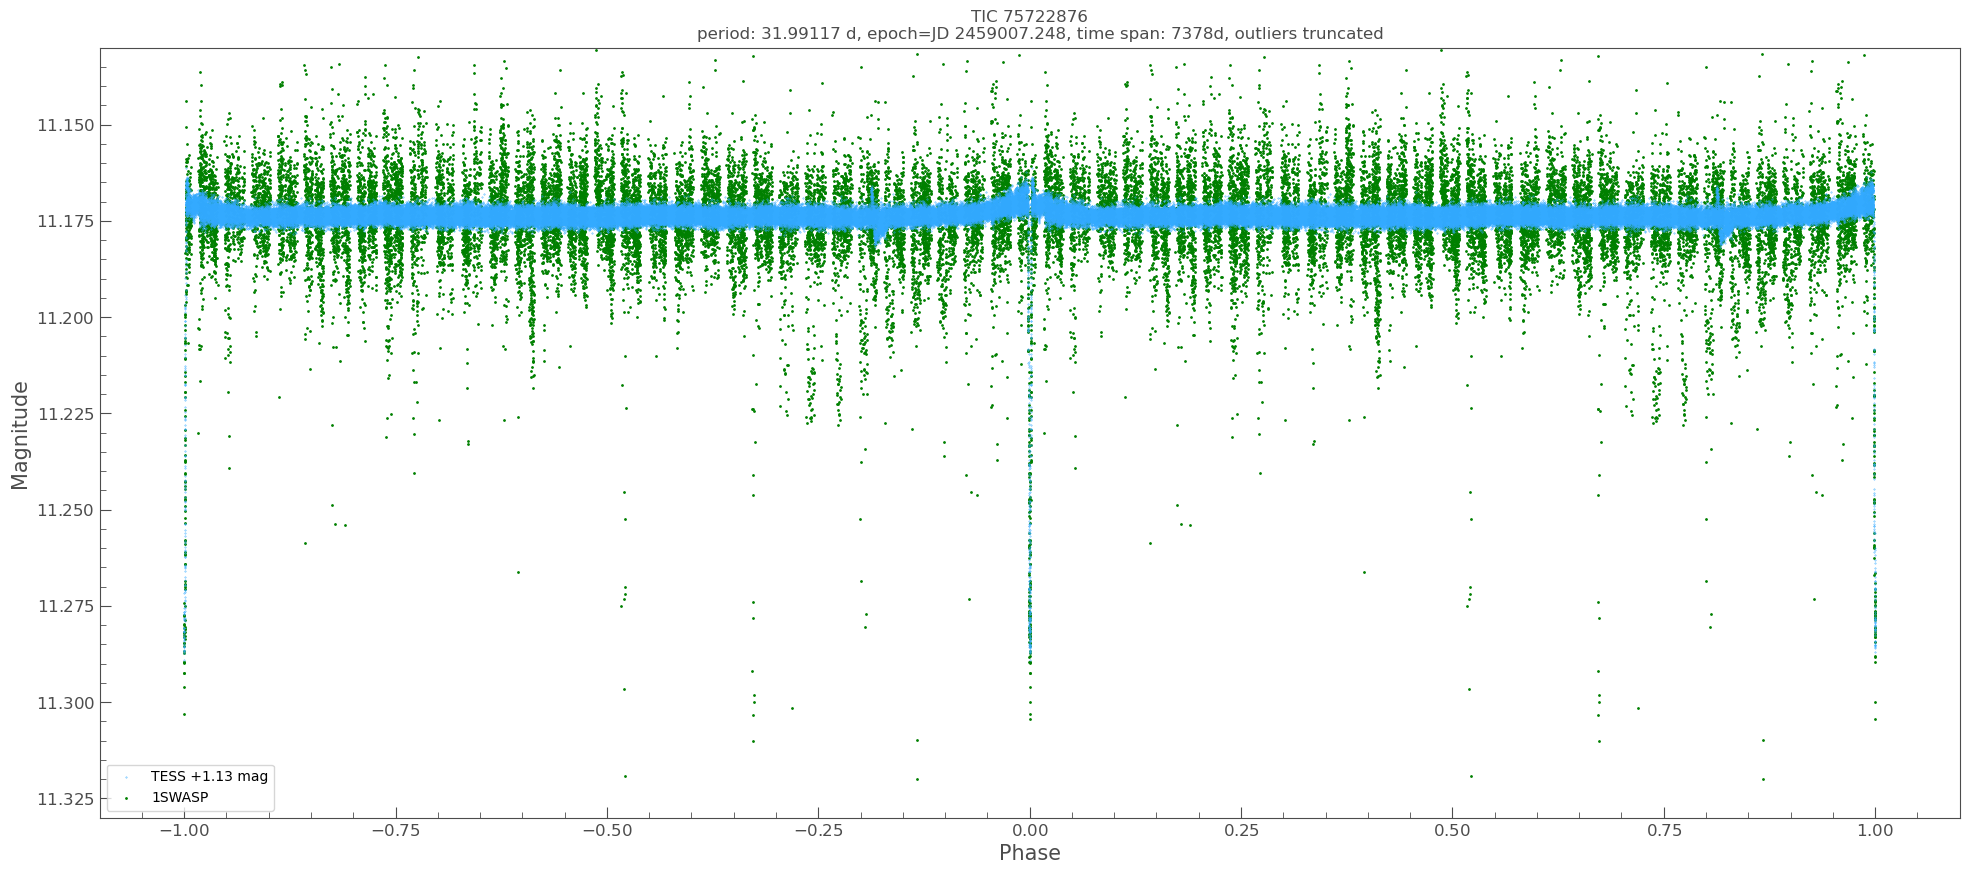

In [171]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 3  # default 2
plot_options[1] = ('scatter', {'c': 'green', 's': 1, 'alpha': 1.0})  # the error for SupeWARSP is so large that it distracts the plot

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (11.33, 11.13)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + ", outliers truncated");


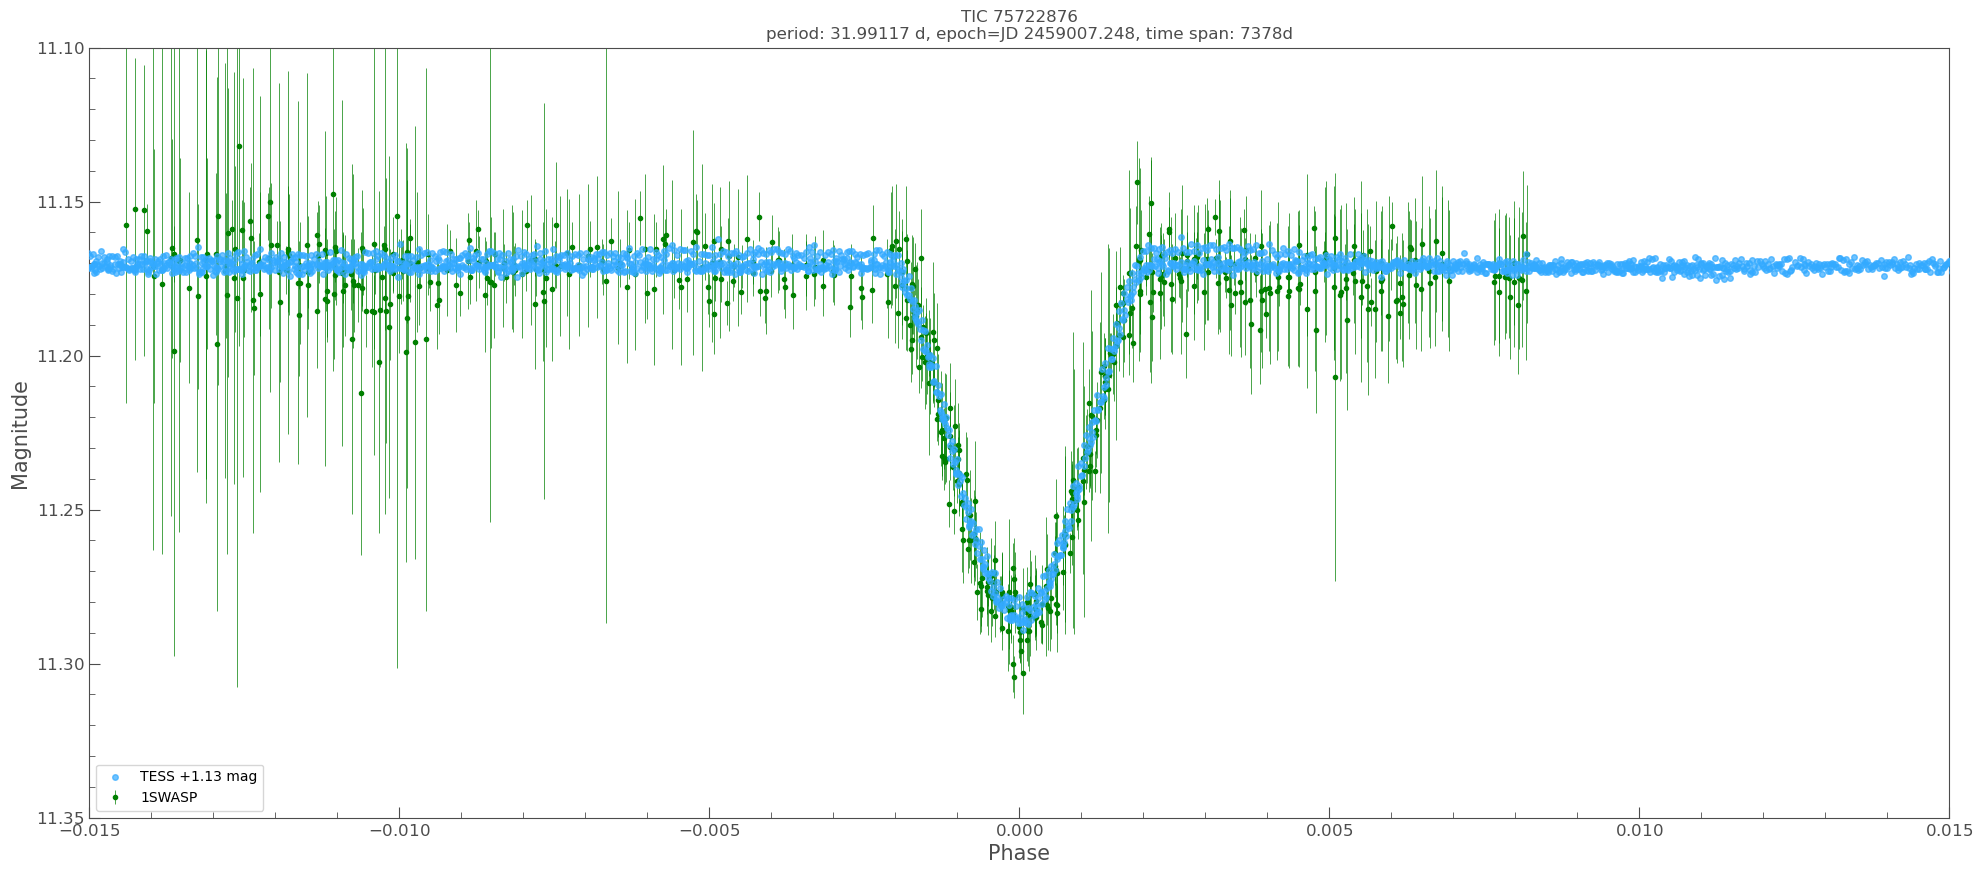

In [204]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 16 # larger dots
plot_options_zoom[0][1]["zorder"] = 3  # default 2
plot_options_zoom[0][1]["alpha"] = 0.7
plot_options[1] =  ('errorbar', {'marker': '.', 'c': 'green', 'linewidth': 0.01, 'ls': 'none', 'alpha': 0.5})
 

# to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
_lc = lc_combined_dict['TESS'].copy()
_lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.015, 0.015);  # to see primary in details
# ax.set_xlim(-0.02, 0.02); 
# ax.set_xlim(-0.007, 0.007);  # to see primary in further details


# # zoom plot - Min II
# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     # lc_combined_dict,
#     dict(TESS=_lc), 
#     period=period_final  ,
#     epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_name=primary_name,
#     # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
#     duration_midpoint_phase=epoch_phase_min_ii_final  ,
#     plot_options=plot_options_zoom,
#     figsize=(24, 10),
#     # mag_shift_precision=2,  #
# );
# ax.set_ylim(*ylim);
# ax.legend(loc="lower left");
# ax.set_xlim(epoch_phase_min_ii_final  -0.07, epoch_phase_min_ii_final  +0.07);  # to see Min II in details


## VSX Report Table

In [139]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [ ]:
# Note: (El-Badry+, 2018) reported the target is a wide binary (sep: ~5"), but Gaia DR3 data suggests they are not bound (plx differfence)
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ692f67cf33b22a&-out.add=.&-source=J/MNRAS/480/4884/tablee1&recno=11492

# In NSVS Catalog, but I don't know how to get the data, nor is there an NSVS name
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ692f67cf33b22a&-out.add=.&-source=II/287/skydot&recno=5370134

In [208]:
import bibs_utils
# reload(bibs_utils)


other_names = f"TYC 3102-253-1,2MASS J18034881+3857379"  # ExoFOP  and  SIMBAD
other_names += ",GSC 03102-00253,WDS J18038+3857A"  # -- other useful names in SIMBAD

remarks = (
    f"""Period might be twice the given. """
    f"""WDS Component B is 73" away. """  # -- https://vizier.cds.unistra.fr/viz-bin/VizieR-S?WDS%20J18038%2b3857
)

# Type, period, epoch, amplitudes, and eclipse duration from TESS and SuperWASP data.
revision_comment = "Mean magnitude derived from Tycho-2 . Position and spectral type from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="K",  # Gaia DR3
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"11.03",  # from Tycho-2, which in turn used by SIMBAD  -- https://vizier.cds.unistra.fr/viz-bin/VizieR-S?TYC%203102-253-1  -- Gaia DR3 Vmag: 11.008
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_flux_mag}",   # in TESS from the plot above
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.1f}",  # 1 decimal point is enough visually
    Discoverer="Sam Lee, Planet Hunters TESS Collaboration",  # PHT Talk: https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/subjects/113562645, https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/search?query=TIC%2075722876
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.TESS_SPOC_N,
    Reference1_Bib=BIBS.TESS_SPOC_B,
    Reference2_Name=BIBS.TESS_SPOC_N,
    Reference2_Bib=BIBS.TESS_SPOC_B,
    Reference3_Name=BIBS.SWASP_N,
    Reference3_Bib=BIBS.SWASP_B,
    Reference4_Name=BIBS.WDS_N,
    Reference4_Bib=BIBS.WDS_B,
)
# Possibly useful references but has no new data
# Czavalinga, D. R.; et al., 2023, New compact hierarchical triple system candidates identified using Gaia DR3  --- 2023A&A...670A..75C
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686bf881147f7d&-out.add=.&-source=J/A%2bA/670/A75/table1&recno=11
# - identifies the target as an EB with ETV (1 of hundreds), but no specific data
#
# Tokovinin, A., 2018, Updated Multiple Star Catalog (MSC): Dec 2023 (Tokovinin, 2018)  --- 2018yCat..22350006T
# https://vizier.cds.unistra.fr/viz-bin/VizieR-6?-source=J/ApJS/235/6/%2a&ID=17560%2b4552
# - in MSC


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic193822785_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
# Zoom not needed
# tic193822785_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom) - EA Phase Plot, zoomed to Min I.
# tic193822785_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom) - EA Phase Plot, zoomed to Min II.
print("""
tic75722876_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS (SPOC PDCSAP_FLUX) and SuperWASP data, shifted to SuperWASP.
tic75722876_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I. The bump around Min I is due to isolated bump around HJD 2460324 in TESS SPOC PDCSAP_FLUX: likely to be a processing glitch as it is not found in SAP_FLUX.
""")


Other Names (1 line each):
TYC 3102-253-1
2MASS J18034881+3857379
GSC 03102-00253
WDS J18038+3857A

Period might be twice the given. WDS Component B is 73" away. 

Mean magnitude derived from Tycho-2 . Position and spectral type from Gaia DR3.


,Field,Value
0,Position,"270.95335732159, 38.96054187664"
1,Primary_Name,TIC 75722876
2,Other_Names,"TYC 3102-253-1,2MASS J18034881+3857379,GSC 03102-00253,WDS J18038+3857A"
3,Variable_Type,EA
4,Spectral_Type,K
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,11.03
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,0.112
9,Minimum_Magnitude_band,TESS



tic75722876_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS (SPOC PDCSAP_FLUX) and SuperWASP data, shifted to SuperWASP.
tic75722876_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom)- EA Phase Plot, zoomed to Min I. The bump around Min I is due to isolated bump around HJD 2460324 in TESS SPOC PDCSAP_FLUX: likely to be a processing glitch as it is not found in SAP_FLUX.

